# AlexNet Retrain using custom layers

### Imports

In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Convolution2D, MaxPooling2D, ZeroPadding2D, Conv2D, BatchNormalization
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import cv2, numpy as np
import matplotlib.pyplot as plt
import itertools
import os
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


### Setup Trainer

In [22]:
train_data_dir = "m_trn"
validation_data_dir = "m_val"
test_data_dir = "m_val"
nb_train_samples = 848 #1313
nb_validation_samples = 313 #454
batch_size = 30
epochs = 50

In [3]:
# plot images with labels
def plots(imgs, figsize=(12,6), rows=2, interp=False, titles=None):
    if type(imgs[0]) is np.ndarray:
        imgs = np.array(imgs).astype(np.uint8)
        if (imgs.shape[-1]!=3):
            imgs = imgs.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(imgs)//rows if len(imgs)%2 == 0 else len(imgs)//rows+1
    for i in range(len(imgs)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=14)
        plt.imshow(imgs[i], interpolation=None if interp else 'none')

In [15]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
fill_mode = "nearest",
zoom_range = 0.2,
width_shift_range = 0.2,
height_shift_range=0.2,
rotation_range=30
)

test_datagen = ImageDataGenerator(
rescale = 1./255,
fill_mode = "nearest",
zoom_range = 0.2,
width_shift_range = 0.2,
height_shift_range=0.2,
rotation_range=30
)

In [16]:
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size=(224,224),
batch_size = batch_size,
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size=(224,224),
class_mode = "categorical")

Found 848 images belonging to 10 classes.
Found 271 images belonging to 10 classes.


### Look at some Memes!

In [6]:
train_batches = ImageDataGenerator().flow_from_directory(train_data_dir, target_size=(224,224), batch_size=4)

Found 848 images belonging to 10 classes.


In [7]:
for (dirpath, dirnames, filenames) in os.walk('m_trn'):
    print(dirnames)
    meme_labels = dirnames
    break

['Art Classical', 'Cartoons', 'Comics Original', 'Doggo n Kitty', 'Drake', 'Escalating', 'Stock', 'Texts', 'Twitter FB Forums', 'World']


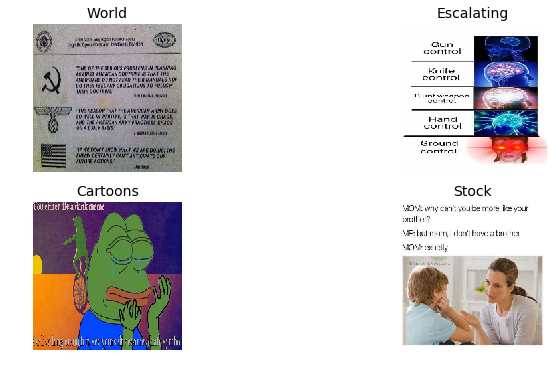

In [9]:
imgs, labels = next(train_batches)
c = []
for l in labels:
    for i in range(len(l)):
        if l[i]>0:
            c.append(meme_labels[i])
plots(imgs, titles=c)

### Build AlexNet Model

In [10]:
model = Sequential()
print('building AlexNet model')

# 1st Convolutional Layer
model.add(Conv2D(activation = 'relu', filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(activation = 'relu', filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(activation = 'relu', filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(BatchNormalization())

# 4th Convolutional Layer
model.add(Conv2D(activation = 'relu', filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(BatchNormalization())

# 5th Convolutional Layer
model.add(Conv2D(activation = 'relu', filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
model.add(BatchNormalization())

# Passing it to a dense layer
model.add(Flatten())
# 1st Dense Layer
model.add(Dense(4096, activation = 'relu', input_shape=(224*224*3,)))
# Added Dropout to prevent overfitting
model.add(Dropout(0.4))
model.add(BatchNormalization())
# 2nd Dense Layer
model.add(Dense(4096,activation = 'relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
# 3rd Dense Layer
model.add(Dense(1000, activation = 'relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Output Layer
model.add(Dense(10,activation = 'softmax'))

model.summary()

building AlexNet model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 384)       

In [11]:
model.compile(optimizers.Adam(lr=0.0001), loss = 'categorical_crossentropy',metrics=['accuracy'])

In [12]:
checkpoint = ModelCheckpoint("alex_new_small.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [13]:
#initial trial
model.fit_generator(
train_generator,
steps_per_epoch = nb_train_samples/batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = nb_validation_samples/batch_size,
callbacks = [checkpoint, early])

Epoch 1/50
85/84 [==============================] - 29s 343ms/step - loss: 2.6783 - acc: 0.2088 - val_loss: 3.2453 - val_acc: 0.2117

Epoch 00001: val_acc improved from -inf to 0.21172, saving model to alex_new_small.h5
Epoch 2/50
85/84 [==============================] - 22s 263ms/step - loss: 2.5072 - acc: 0.2559 - val_loss: 2.4085 - val_acc: 0.3285

Epoch 00002: val_acc improved from 0.21172 to 0.32845, saving model to alex_new_small.h5
Epoch 3/50
85/84 [==============================] - 23s 267ms/step - loss: 2.4524 - acc: 0.2938 - val_loss: 2.3404 - val_acc: 0.3165

Epoch 00003: val_acc did not improve from 0.32845
Epoch 4/50
85/84 [==============================] - 22s 261ms/step - loss: 2.4005 - acc: 0.3044 - val_loss: 2.1400 - val_acc: 0.3368

Epoch 00004: val_acc improved from 0.32845 to 0.33682, saving model to alex_new_small.h5
Epoch 5/50
85/84 [==============================] - 23s 274ms/step - loss: 2.3478 - acc: 0.3129 - val_loss: 2.6348 - val_acc: 0.3186

Epoch 00005: val

In [17]:
#subsequent trials
model.fit_generator(
train_generator,
steps_per_epoch = nb_train_samples/batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = nb_validation_samples/batch_size,
callbacks = [checkpoint, early])

Epoch 1/50
29/28 [==============================] - 14s 499ms/step - loss: 1.7545 - acc: 0.4533 - val_loss: 1.9169 - val_acc: 0.4030

Epoch 00001: val_acc did not improve from 0.42343
Epoch 2/50
29/28 [==============================] - 14s 497ms/step - loss: 1.6444 - acc: 0.4843 - val_loss: 1.7622 - val_acc: 0.4239

Epoch 00002: val_acc improved from 0.42343 to 0.42388, saving model to alex_new_small.h5
Epoch 3/50
29/28 [==============================] - 14s 490ms/step - loss: 1.5840 - acc: 0.5107 - val_loss: 2.2815 - val_acc: 0.3612

Epoch 00003: val_acc did not improve from 0.42388
Epoch 4/50
29/28 [==============================] - 14s 484ms/step - loss: 1.5757 - acc: 0.5115 - val_loss: 1.8434 - val_acc: 0.4418

Epoch 00004: val_acc improved from 0.42388 to 0.44179, saving model to alex_new_small.h5
Epoch 5/50
29/28 [==============================] - 14s 482ms/step - loss: 1.5945 - acc: 0.4785 - val_loss: 1.9922 - val_acc: 0.3616

Epoch 00005: val_acc did not improve from 0.44179
Ep

In [31]:
test_batches = ImageDataGenerator().flow_from_directory(test_data_dir, target_size=(224,224), batch_size=8)

Found 271 images belonging to 10 classes.


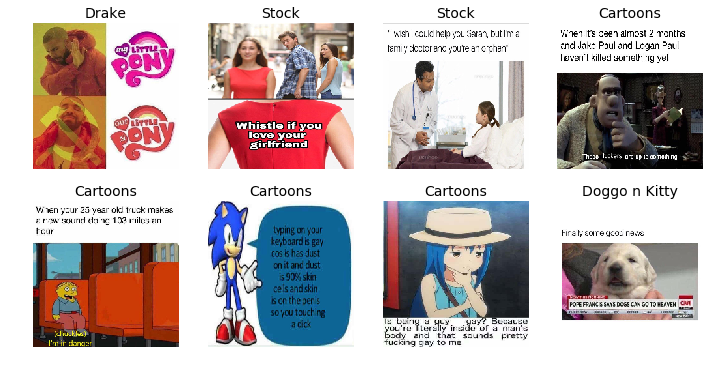

In [32]:
imgs, labels = next(test_batches)
c = []
for l in labels:
    for i in range(len(l)):
        if l[i]>0:
            c.append(meme_labels[i])
plots(imgs, titles=c)

In [40]:
pred = model.predict_generator(test_batches, steps=4, verbose=1)
pred = np.round(pred)
d = []
for l in pred:
    for i in range(len(l)):
        if l[i]>0:
            d.append(meme_labels[i])
print(d)
pred

4/4 [==============================] - 0s 54ms/step
['Drake', 'Drake', 'Twitter FB Forums', 'Drake', 'World', 'Twitter FB Forums', 'World', 'World', 'Twitter FB Forums', 'Twitter FB Forums', 'Drake', 'Drake', 'Drake', 'Drake', 'World', 'Drake', 'Drake', 'Drake', 'Drake', 'Twitter FB Forums', 'World', 'Twitter FB Forums', 'Twitter FB Forums', 'Twitter FB Forums', 'Drake', 'World', 'Twitter FB Forums', 'Drake', 'Twitter FB Forums', 'Twitter FB Forums', 'Drake', 'Drake']


array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 